In [8]:
import numpy as np

In [9]:
from SimPEG import *
from simpegem1d.Waveform import CausalConv
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat
import cPickle as pickle
%pylab inline

ModuleNotFoundError: No module named 'cPickle'

In [ ]:
directory = "/Users/sgkang/Dropbox/Shared/SeogiDikun/Milligan/Data/"
milligan = pickle.load(open(directory+"milligan.p"))

In [10]:
DAT = milligan['DAT']
Header = milligan['header']
tinds = 3
time = milligan['time'][tinds:]
obsdata = DAT[:,13:13+27][:,tinds:]
xyz = np.c_[DAT[:,0], DAT[:,1], DAT[:,3]]
line = milligan['Line']
wave = milligan["wave"] #Derivative of the current (primary voltage)

In [11]:
# Choose line
linenum = 6
# linenum = 0
Line = np.unique(line)
indline = line == Line[linenum]

# Down sample
# obs_line = obsdata[indline,:][::10,:]
# xyz_line = xyz[indline,:][::10,:]
obs_line = obsdata[::10,:]
xyz_line = xyz[::10,:]

(-4.5, 4.5)

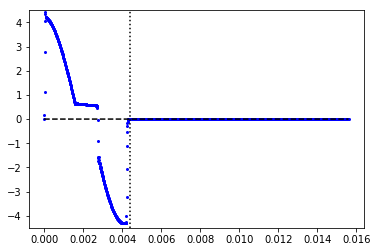

In [12]:
# Set time for a convolution
dt, nt = 1e-5, 1e4
twave = (np.arange(nt)+1)*dt
indstart = 4439
indend = 6000
t0_wave = twave[indstart:indend].min()
time_conv= twave[indstart:indend]-t0_wave
# Get derivative of the current (primary voltage)
currentderiv = wave[indstart:indend]
currentderiv[time_conv>4.4e-3] = 0.
current = CausalConv(wave[indstart:indend], np.ones_like(wave[indstart:indend]), time_conv)

plt.plot(time_conv, wave[indstart:indend], 'b.', lw=2, ms=4)
plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[-4.5, 4.5], 'k:')
plt.ylim(-4.5, 4.5)

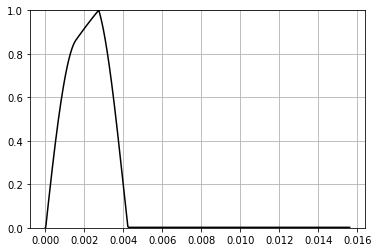

In [13]:
figsize(6, 4)
plt.plot(time_conv, current/current.max(), 'k-')
plt.ylim(0, 1.)
plt.grid(True)

In [18]:
np.save("wave_milligan", np.c_[time_conv, current/current.max()])

In [10]:
from SimPEG import EM

In [16]:
t0_wave

0.044400000000000002

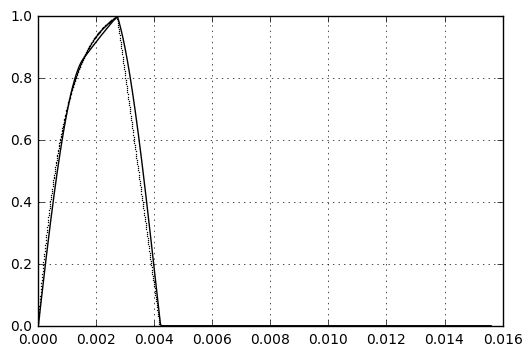

In [23]:
temp = EM.Utils.VTEMFun(time_conv, 0.00273, 4.2e-3, 3.)
figsize(6, 4)
plt.plot(time_conv, current/current.max(), 'k-')
plt.plot(time_conv, temp, 'k.', ms=1.)
plt.ylim(0, 1.)
plt.grid(True)

In [13]:
ind = np.argmax(current)

In [14]:
time_conv[ind]

0.0027300000000000033

In [10]:
# from simpegEMIP.StoltzMacnae import ExpFitProblem, ExpFitSurvey, LineRegularization

In [ ]:
meshline = Mesh.TensorMesh([xyz_line.shape[0]])
prob = ExpFitProblem(meshline, currentderiv=currentderiv, AofT_type="Impulse_Conv")
survey = ExpFitSurvey(time, xyz_line)
prob.pair(survey)
prob.setTau(minlogtau=-5, maxlogtau=-2, ntau=31)
prob.getG(time_conv, t0=4.4e-3)
# prob.getG(time_conv, t0=0.)
uncert = survey.setUncertainty(obs_line.flatten(), perc=0.05, floor=1e-4, floorIP=5e-4)

In [9]:
# mtrue = np.zeros(prob.ntau)
# np.random.seed(1)
# inds = np.random.random_integers(0, 41, size=5)
# mtrue[inds] = np.r_[0.1, 2, 1, 4, 5]
# mtrue = (np.repeat(mtrue.reshape([1,-1]), survey.ntx, axis=0)).flatten()

In [11]:
from SimPEG import Maps

In [12]:
weightone = np.sqrt(np.diag(np.dot(prob.G.T, prob.G)))
weight = (np.repeat(weightone.reshape([1,-1]), survey.ntx, axis=0)).flatten()
meshreg = Mesh.TensorMesh([weight.size])
wmap = Maps.Weighting(meshreg, weights=weight)

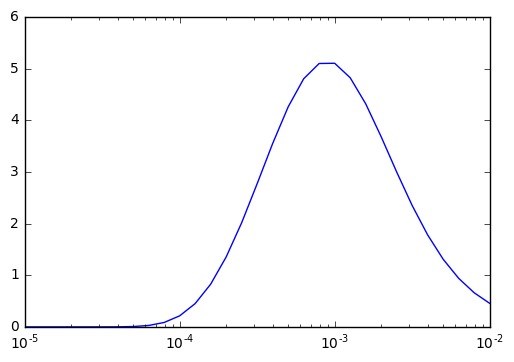

In [13]:
plt.semilogx(prob.tau, weightone)

In [14]:
# reg = Regularization.BaseRegularization(meshreg, mapping=wmap)
# reg = Regularization.BaseRegularization(meshreg)
# reg = LineRegularization(meshreg, mapping=wmap, ntau=prob.ntau)
reg = Regularization.BaseRegularization(meshreg, mapping=wmap)
reg.xyz_line = xyz_line
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(uncert)
opt = Optimization.ProjectedGNCG(maxIter=200, maxIterLS = 40, stepActiveset=False)
# opt = Optimization.InexactGaussNewton(maxIter=100, maxIterLS = 40)
opt.lower = 1e-20
# opt.upper = 1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e-10)
beta = Directives.BetaSchedule()
beta.coolingFactor = 1
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target, betaest])
opt.tolG = 1e-10
opt.tolG = 1e-10
m0 = np.ones_like(weight)*1e-10
reg.mref = np.zeros_like(m0)
mrec = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.50e-04  4.03e+06  1.45e-15  4.03e+06    1.69e+07      0              
   1  5.50e-04  3.02e+06  8.33e-02  3.02e+06    4.95e+06      0              
   2  5.50e-04  2.52e+06  4.94e-01  2.52e+06    2.40e+06      0   Skip BFGS  
   3  5.50e-04  2.00e+06  1.10e+00  2.00e+06    1.48e+06      0              
   4  5.50e-04  1.69e+06  5.12e+00  1.69e+06    4.60e+05      0   Skip BFGS  
   5  5.50e-04  1.16e+06  5.32e+00  1.16e+06    8.90e+05      0              
   6  5.50e-04  9.39e+05  8.11e+00  9.39e+05    6.56e+05      0              
   7  5.50e-04  7.02e+05  1.52e

In [15]:
print target.target, invProb.phi_d

17712.0 17539.9990737


In [16]:
mrec = mrec.reshape((prob.ntau, survey.ntx), order='F')
pred = prob.fields(mrec)
pred = pred.reshape((survey.ntime, survey.ntx), order='F')
obs = survey.dobs.reshape((survey.ntime, survey.ntx), order='F')
obs_nan = obs.copy()
ipraw = obs-pred
obs_nan[obs<0.] = np.nan
UNCERT = survey.uncert.reshape((survey.ntime, survey.ntx), order='F')

<function __main__.vizTau>

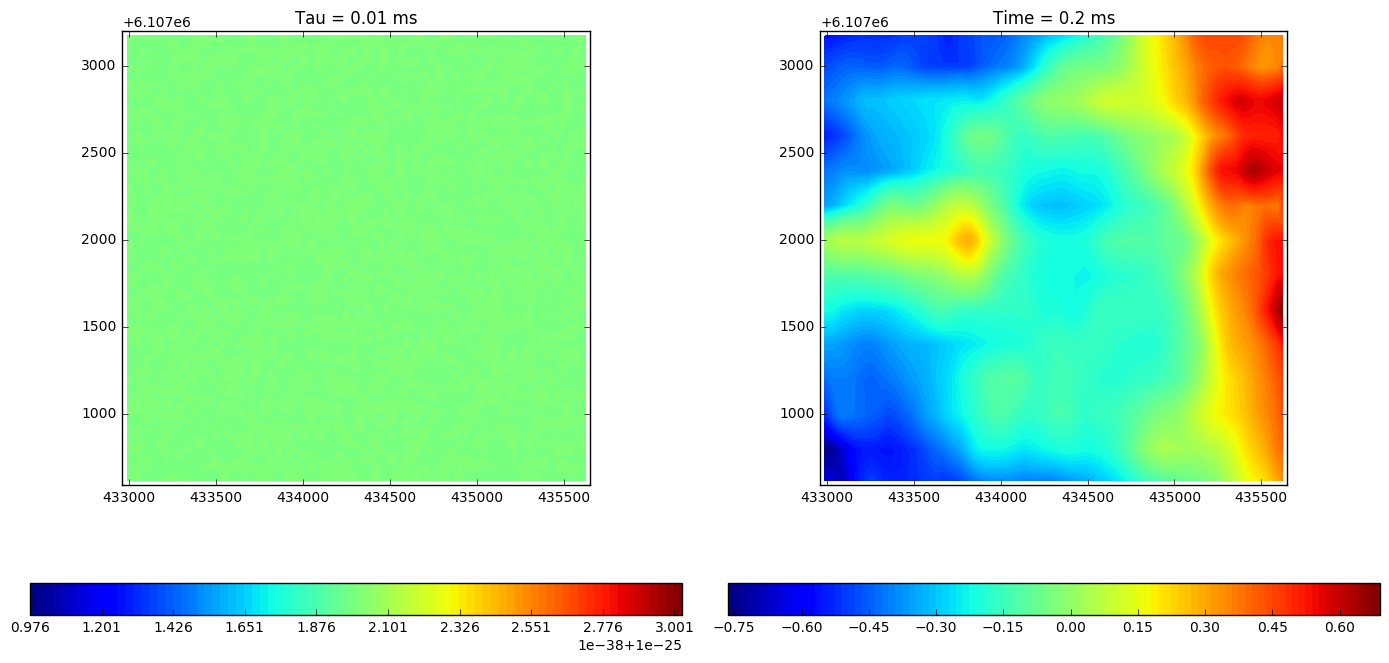

In [17]:
from ipywidgets import *
def vizTau(itau, itime):
    fig = plt.figure(figsize = (14, 7))
    ax1 = plt.subplot(121)   
    ax2 = plt.subplot(122)       
    out1 = Utils.plot2Ddata(xyz_line, mrec[itau,:] * prob.tau[itau], scale='linear', ncontour=100, ax=ax1)
    cb1 = plt.colorbar(out1[0], ax=ax1, orientation="horizontal")
    ax1.set_aspect("equal")
    out2 =Utils.plot2Ddata(xyz_line, obs_nan[itime,:], scale='log', ncontour=100, ax=ax2)    
    cb2 = plt.colorbar(out2[0], ax=ax2, orientation="horizontal")    
    ax1.set_title(("Tau = %.2f ms")%(prob.tau[itau]*1e3))
    ax2.set_title(("Time = %.1f ms")%(survey.time[itime]*1e3))  
    plt.tight_layout()
interact(vizTau, itau=IntSlider(min=0, max=len(prob.tau)-1, step=1), 
        itime=IntSlider(min=0, max=len(survey.time)-1, step=1))

(<matplotlib.contour.QuadContourSet at 0x10bb7b1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e99bed0>)

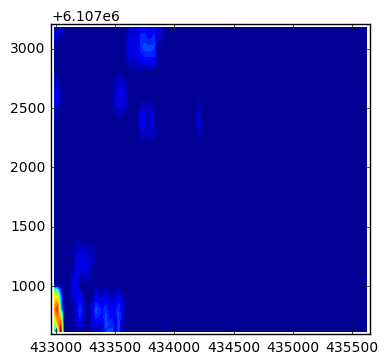

In [18]:
Utils.plot2Ddata(xyz_line, prob.tau[np.argmax(Utils.sdiag(prob.tau)*mrec, axis=0)], scale='log', ncontour=30)

(<matplotlib.contour.QuadContourSet at 0x10b26d710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10ee79990>)

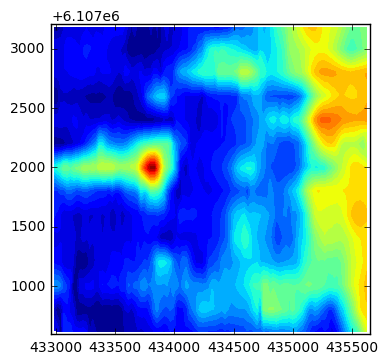

In [19]:
Utils.plot2Ddata(xyz_line, (Utils.sdiag(prob.tau) * mrec).sum(axis=0), scale='linear', ncontour=30)

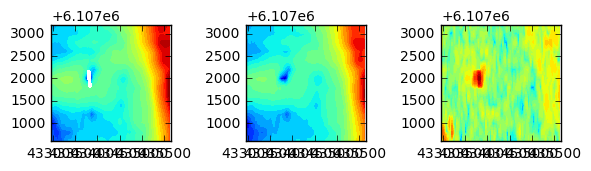

In [33]:
i=10
fig = plt.figure()
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
vmin, vmax = np.log10(pred[i,:]).min(), np.log10(pred[i,:]).max()
Utils.plot2Ddata(xyz_line, obs_nan[i,:], scale='log', ax=ax1, ncontour=30, clim=(vmin, vmax))
ax1.set_aspect('equal')
Utils.plot2Ddata(xyz_line, pred[i,:], scale='log', ax=ax2, ncontour=30, clim=(vmin, vmax))
ax2.set_aspect('equal')
Utils.plot2Ddata(xyz_line, abs(ipraw[i,:]) /(abs(pred[i,:])+1e-3), scale='log', ax=ax3, ncontour=30)
plt.tight_layout()

In [27]:
# obsmap, ticks, ticklabels = mapDat(obs, 1e-3, stretch=3)
# predmap, ticks, ticklabels = mapDat(pred, 1e-3, stretch=3)
# # iprawmap, ticks, ticklabels = mapDat(ipraw, 1e-3, stretch=3)


# itx = 100
# fig = plt.figure(figsize=(10,3))
# ax = plt.subplot(111)
# for i in range(20):
#     ax.plot(xyz_line[:,0], obsmap[i,:], 'k')
#     ax.plot(xyz_line[:,0], predmap[i,:], 'b.')
# #     ax.plot(xyz_line[:,0], iprawmap[i,:], 'r.')
# ax.set_xlim(xyz_line[:,0].min(), xyz_line[:,0].max())
# ax.set_ylim(ticks.min(), ticks.max())
# ax.set_yticks(ticks)
# # ax.set_ylim(0., ticks.max())
# # ylim(1e-4, 1e1)
# # xlim(1e-4, 1e-2)
# plt.plot(xyz_line[itx,0]*np.ones(2), np.r_[ticks.min(), ticks.max()],'k-', lw=2)
# ax.set_xlabel("Easting (m)")
# ax.set_yticklabels(ticklabels)

In [22]:
# temp = mrec.copy()
# actinds = temp > 1e-5
# temp[~actinds] = np.nan
# fig = plt.figure(figsize = (10, 4))
# vmin, vmax = np.log10(temp[actinds]).min(), np.log10(temp[actinds]).max()
# out = plt.pcolormesh(xyz_line[:,0], prob.tau, np.log10(mrec), clim=(vmin, vmax), vmin=vmin, vmax=vmax)
# plt.colorbar(out, orientation="horizontal")
# plt.yscale("log")
# plt.xlim(xyz_line[:,0].min(), xyz_line[:,0].max())
# plt.ylim(1e-5, 2e-3)
# plt.tight_layout()

In [26]:
# itx = 100
# figsize(6,5)
# plt.loglog(time, pred[:,itx], 'b-')
# plt.loglog(time, -pred[:,itx], 'b--')
# plt.loglog(time, obs[:,itx], 'k.-')
# plt.loglog(time, -obs[:,itx], 'k--')
# plt.loglog(time, -ipraw[:,itx], 'r--')
# plt.loglog(time, UNCERT[:,itx], 'g-')
# ylim(1e-4, 1e1)
# xlim(1e-4, 1e-2)

In [24]:
# for itx in range(survey.ntx):
#     plt.semilogx(prob.tau, mrec[:,itx], '.')
# plt.grid(True)

In [25]:
# fig = plt.figure(figsize=(5,4))
# ax = plt.subplot(111)

# # for i, ind in enumerate(inds):
# #     temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
# #     plt.semilogx(time, temp, 'k', alpha = 0.5)    
# outmap, ticks, tickLabels = mapDat(obs,1e-3, stretch=3)    
# ax.plot(time*1e6, outmap, 'k', lw=1)
# ax.plot(time*1e6, predmap, 'b.', ms=2)
# # ax.plot(time*1e6, iprawmap, 'r.', ms=2)
# # ax.plot(time[7:]*1e6, outmap[7:]-predmap[7:], 'r', lw=2)
# ax.plot(np.r_[-0.002, 0.]*1e6, np.zeros(2), 'k', lw=2)
# ax.plot(np.zeros(2), np.r_[ticks.min(), ticks.max()], 'k--', lw=1)
# ax.set_yticks(ticks)
# ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
# ax.plot(np.r_[-0.002, time.max()]*1e6, np.zeros(2), 'k--')
# ax.set_xlim(-0.002*1e6, time.max()*1e6)

# ax.set_xlabel("Time (micro-s)", fontsize = 16)
# ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)

# # ax.grid(True)